In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#how many models we want to have
total_models=11

def LDM(params,x):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    n=x[0]
    z=x[1]

    return params[0]*(n+z) - params[1]*(n+z)**(2/3) - params[2]*((n-z)**2/(n+z)) - params[3]*((z**2)/((n+z)**(1/3)))

def LDM_quadratic_bias(params,x, a = 0.25):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    #a = quadratic corruption coefficient
        n=x[0]
        z=x[1]
        return LDM(params,x) - a * (n+z) ** 2
    
    
LDM_truth_params=[14,13.3,0.57,17]

def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    plt.show()
    return

# Data generation

In [201]:
#Noise level we will use to "wiggle" all the model predictions a bit
corruption_noise_Mass=10

# Fix random seed
np.random.seed(42)

# Load NZ
input_NZ =  data_loader()


masses_truth = Truth([input_NZ["Z"], input_NZ["N"]])
masses_distorted = LDM_quadratic_bias(LDM_truth_params,[input_NZ["Z"], input_NZ["N"]], a = 0.5)

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
for i in range(n_class_1):
    models_output["c1_" + str(i)] = masses_truth + np.random.randn(len(masses_truth)) * corruption_noise_Mass

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
for i in range(n_class_2):
    models_output["c2_" + str(i)] = masses_distorted + np.random.randn(len(masses_truth)) * corruption_noise_Mass

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

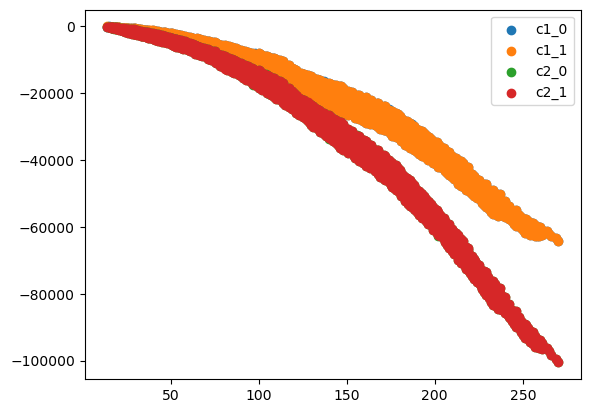

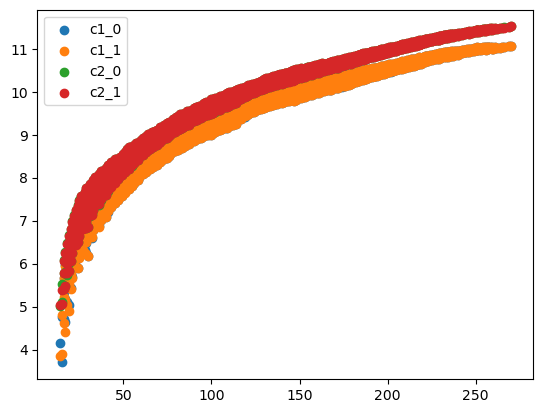

[[1.         0.99999963 0.99922151 0.99922188]
 [0.99999963 1.         0.99922249 0.99922285]
 [0.99922151 0.99922249 1.         0.99999983]
 [0.99922188 0.99922285 0.99999983 1.        ]]


In [208]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key)
plt.legend()
plt.show()

for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = np.log(-models_output_df[key]), label = key)
plt.legend()
plt.show()
print(np.corrcoef(models_output_df[models_output.keys()].values.T))


# PCA - model output is not standardized

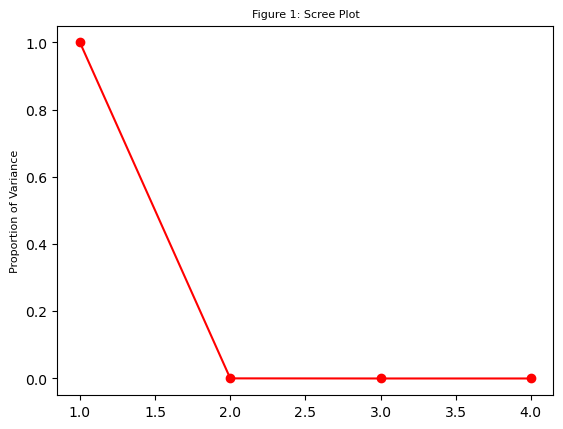

In [180]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(models_output_df[models_output.keys()])

prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

In [181]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)
print(loadings)

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0          -0.386263  0.592548 -0.147099  0.691412
c1_1          -0.386265  0.592020  0.147443 -0.691789
c2_0          -0.592284 -0.386417  0.691488  0.147396
c2_1          -0.592284 -0.386110 -0.691713 -0.147147


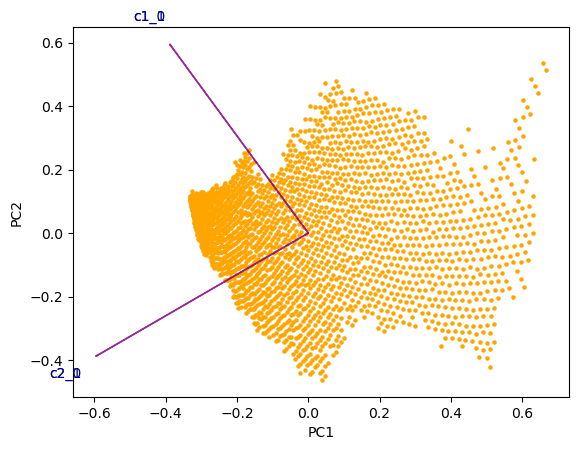

In [182]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

# PCA - model output is standardized

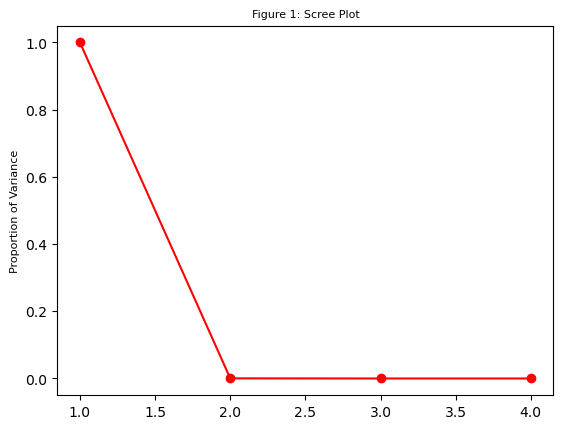

In [183]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(models_output_df[models_output.keys()])
X_pca = pca.fit_transform(X_scaled)

prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

In [184]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)
print(loadings)

               PC1       PC2       PC3       PC4
feature_names                                   
c1_0          -0.5  0.500315  0.706738  0.014356
c1_1          -0.5  0.499685 -0.707187 -0.014197
c2_0          -0.5 -0.500119 -0.014052  0.706883
c2_1          -0.5 -0.499881  0.014500 -0.707042


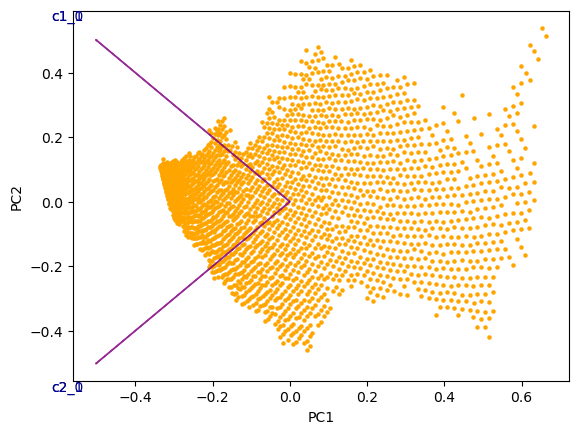

In [185]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

# PCA on residuals - residuals are not standardized

In [231]:
residuals = models_output_df[models_output.keys()].values - masses_truth.values[:,None]
np.corrcoef(residuals.T)

array([[1.        , 0.02540095, 0.01106168, 0.01105382],
       [0.02540095, 1.        , 0.02510892, 0.02506289],
       [0.01106168, 0.02510892, 1.        , 0.99999862],
       [0.01105382, 0.02506289, 0.99999862, 1.        ]])

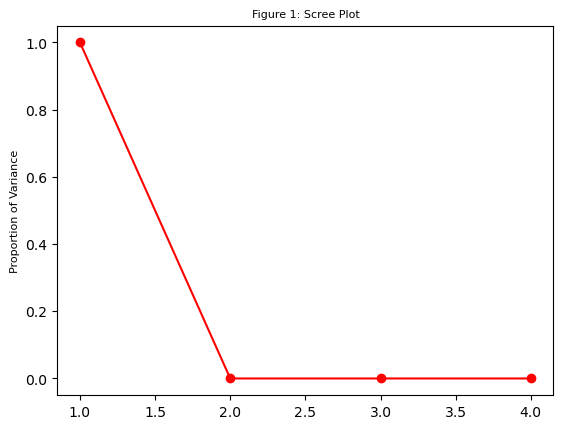

In [232]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(residuals)

prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

In [237]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)
print(loadings)

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0          -0.016510  0.713978  0.699973 -0.000005
c1_1          -0.035814  0.699197 -0.714031 -0.000032
c2_0          -0.706557 -0.026044  0.009904  0.707107
c2_1          -0.706556 -0.026081  0.009932 -0.707106


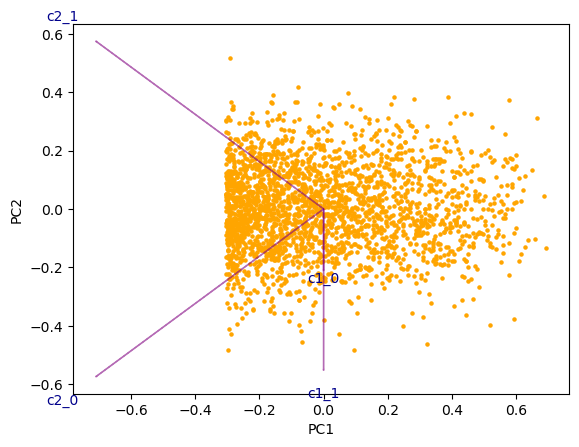

In [234]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

# PCA on residuals - residuals are standardized

In [ ]:
residuals = models_output_df[models_output.keys()].values - masses_truth.values[:,None]
np.corrcoef(residuals.T)

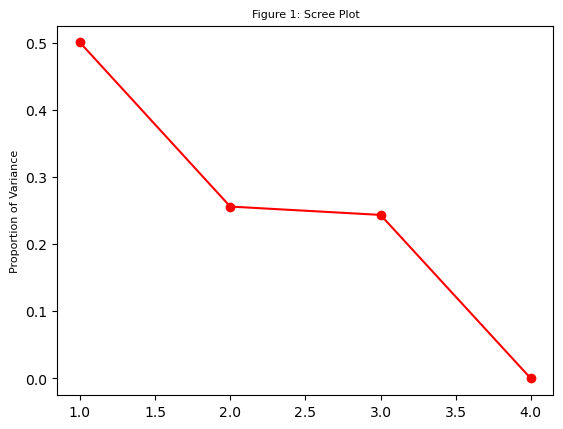

In [236]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(residuals)
X_pca = pca.fit_transform(X_scaled)

prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

In [239]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)
print(loadings)

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0          -0.016510  0.713978  0.699973 -0.000005
c1_1          -0.035814  0.699197 -0.714031 -0.000032
c2_0          -0.706557 -0.026044  0.009904  0.707107
c2_1          -0.706556 -0.026081  0.009932 -0.707106


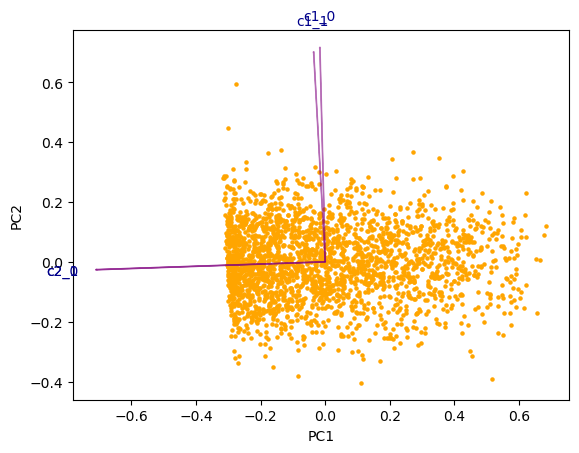

In [240]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))